In [57]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [58]:
import numpy as np
import pandas as pd

In [59]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [60]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect,func,distinct

In [61]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [62]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [63]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [64]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [65]:
# get the column information of each tables
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for column in measurement_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [66]:
station_columns = inspector.get_columns("station")
for column in station_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [67]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Step 1 - Exploratory Climate Analysis and Exploration

### 1.Precipitation Analysis

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(measurements.date).order_by(measurements.date.desc()).first()[0]
last_day

'2017-08-23'

In [69]:
last_day = dt.datetime.strptime(last_day,"%Y-%m-%d").date()
one_year_ago = last_day.replace(last_day.year-1)
one_year_ago 

datetime.date(2016, 8, 23)

#### Precipitation results of last 12 months in the dataset

In [70]:
# Perform a query to retrieve the data and precipitation scores
precipitation_12 = session.query(measurements.date,measurements.prcp).filter(measurements.date>=one_year_ago).all()
precipitation_12

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [71]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_12,columns=['Date','Precipitation Scores'])
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date",ascending=True)
precipitation_df = precipitation_df.dropna(how='any')
precipitation_df = precipitation_df.reset_index(drop=True)
precipitation_df['Precipitation Scores'].max()
count = precipitation_df['Precipitation Scores'].count()
precipitation_df = precipitation_df.set_index('Date')
precipitation_df

,Precipitation Scores
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


#### Precipitation results in all years

In [53]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_all = session.query(measurements.date,measurements.prcp).all()
precipitation_all_df = pd.DataFrame(precipitation_all,columns=['Date','Precipitation Scores'])
precipitation_all_df = precipitation_all_df.sort_values("Date",ascending=True).\
                                            dropna(how='any').\
                                            reset_index(drop=True).\
                                            set_index('Date')
precipitation_all_df.to_csv("../Output/precipitations.csv", index=True, header=True) 
# precipitation_all_dict = precipitation_all_df.to_dict()["Precipitation Scores"]
# precipitation_all_dict

Text(0, 0.5, 'Inches')

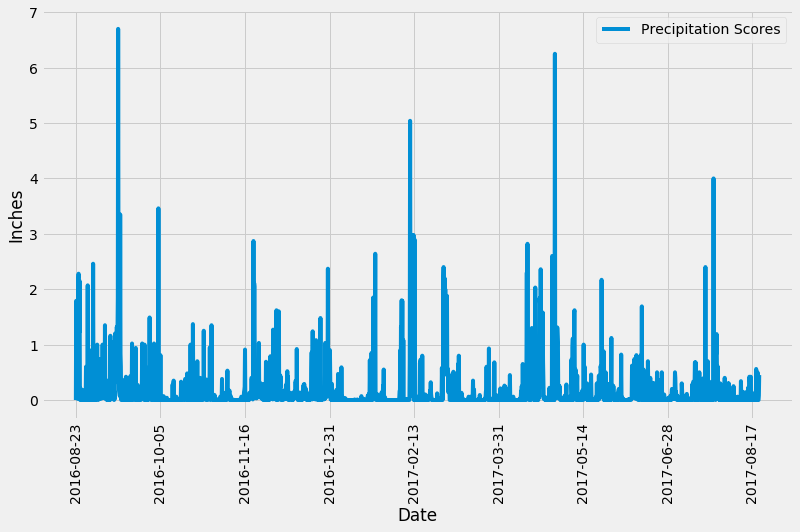

In [72]:
# Use Pandas Plotting with Matplotlib to plot the data
plot1 = precipitation_df.plot(kind="line",rot=90,figsize=(12,7))
plot1.set_ylabel("Inches")

In [73]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df["Precipitation Scores"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation Scores, dtype: float64

### 2.Station Analysis

In [74]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurements.station).\
                    distinct().count()
print(f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [75]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel1 = [measurements.station, 
        func.count(measurements.prcp),]

active_station = session.query(*sel1).\
                    group_by(measurements.station).\
                    order_by(func.count(measurements.prcp).\
                    desc()).first()

# retrieve the information of this most active station.
sel2 = [stations.station,stations.name,stations.latitude,stations.longitude]
active_station_info = session.query(*sel2).filter(stations.station == active_station[0]).all()[0]
print(f"The most active station is {active_station[0]} with {active_station[1]} data points")
print(f"This station is located at {active_station_info[1]}: latitude:{round(active_station_info[2],2)}, longitude:{round(active_station_info[3],2)}")


The most active station is USC00519281 with 2772 data points
This station is located at WAIHEE 837.5, HI US: latitude:21.45, longitude:-157.85


In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel3 = [func.min(measurements.tobs),
        func.max(measurements.tobs),
        func.avg(measurements.tobs)]
active_station_describe = session.query(*sel3).\
                    filter(stations.station == active_station[0]).all()[0]
print(f''' 
    Station ID: {active_station[0]};
    Location: {active_station_info[1]};
    Lowest temperature recorded:{active_station_describe[0]};
    Highest temperature recorded:{active_station_describe[1]};
    Average temperature:{active_station_describe[2]};
''')


 
    Station ID: USC00519281;
    Location: WAIHEE 837.5, HI US;
    Lowest temperature recorded:53.0;
    Highest temperature recorded:87.0;
    Average temperature:73.09795396419437;



In [79]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel4 = [measurements.date,measurements.tobs]
active_station_tobs = session.query(*sel4).filter(measurements.station == active_station[0]).\
                            filter(measurements.date>=one_year_ago).\
                            order_by(measurements.date).all()
active_station_tobs

In [81]:
# save the temperature date of the most active station for the last year of data
active_station_tobs_df = pd.DataFrame(active_station_tobs,columns=['Date','Temperature'])
active_station_tobs_df = active_station_tobs_df.sort_values("Date",ascending=True).\
                                            dropna(how='any').\
                                            reset_index(drop=True).\
                                            set_index('Date')
active_station_tobs_df.to_csv("../Output/tem_active_station.csv", index=True, header=True)

In [86]:
 
pd.read_csv("../Output/tem_active_station.csv").set_index("Date").to_dict()["Temperature"]

{'2016-08-23': 77.0,
 '2016-08-24': 77.0,
 '2016-08-25': 80.0,
 '2016-08-26': 80.0,
 '2016-08-27': 75.0,
 '2016-08-28': 73.0,
 '2016-08-29': 78.0,
 '2016-08-30': 77.0,
 '2016-08-31': 78.0,
 '2016-09-01': 80.0,
 '2016-09-02': 80.0,
 '2016-09-03': 78.0,
 '2016-09-04': 78.0,
 '2016-09-05': 78.0,
 '2016-09-06': 73.0,
 '2016-09-07': 74.0,
 '2016-09-08': 80.0,
 '2016-09-09': 79.0,
 '2016-09-10': 77.0,
 '2016-09-11': 80.0,
 '2016-09-12': 76.0,
 '2016-09-13': 79.0,
 '2016-09-14': 75.0,
 '2016-09-15': 79.0,
 '2016-09-16': 78.0,
 '2016-09-17': 79.0,
 '2016-09-18': 78.0,
 '2016-09-19': 78.0,
 '2016-09-20': 76.0,
 '2016-09-21': 74.0,
 '2016-09-22': 77.0,
 '2016-09-23': 78.0,
 '2016-09-24': 79.0,
 '2016-09-25': 79.0,
 '2016-09-26': 77.0,
 '2016-09-27': 80.0,
 '2016-09-28': 78.0,
 '2016-09-29': 78.0,
 '2016-09-30': 78.0,
 '2016-10-01': 77.0,
 '2016-10-02': 79.0,
 '2016-10-03': 79.0,
 '2016-10-04': 79.0,
 '2016-10-05': 79.0,
 '2016-10-06': 75.0,
 '2016-10-07': 76.0,
 '2016-10-08': 73.0,
 '2016-10-09'

Text(0.5, 0, 'Tempreture')

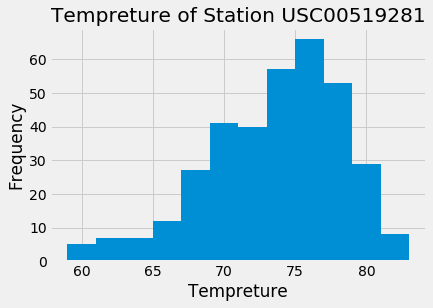

In [78]:
active_station_tobs
a_tobs = [tobs[1]for tobs in active_station_tobs]
# a_date = [tobs[0]for tobs in active_station_tobs]
# tobs_df = pd.DataFrame({"Date": a_date, "Temperature":a_tobs})
# tobs_df.dropna(how="any")
plt.hist(a_tobs,bins=12)
plt.title(f"Tempreture of Station {active_station[0]}")
plt.ylabel("Frequency")
plt.xlabel("Tempreture")

# Step 2 - Climate App

## Bonus Challenge Assignment

### 1. Temperature Analysis

In [87]:
from scipy import stats

In [88]:
# read the csv file into dataframe
measurement_df = pd.read_csv("../Resources/hawaii_measurements.csv")
measurement_df.sort_values("date").head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
9007,USC00518838,2010-01-01,0.21,72
9518,USC00519523,2010-01-01,0.15,75
12187,USC00519281,2010-01-01,0.15,70
14959,USC00511918,2010-01-01,0.05,66


In [89]:
station_df = pd.read_csv("../Resources/hawaii_stations.csv")

station_df.head()
# from flask import jsonify

# dict = station_df.set_index('station').to_dict(orient='records')
# jsonify(dict)

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [90]:
# retrieve the average temperature in June/December at all stations accross all available years
measurement_df["date"] = pd.to_datetime(measurement_df["date"])
measurement_df["year"] = measurement_df["date"].dt.year
measurement_df["month"] = measurement_df["date"].dt.month
june_df = measurement_df[["station","year","month","tobs"]].loc[measurement_df["month"]==6]
june_mean = june_df.groupby("year").mean()
june_mean

,month,tobs
year,,
2010,6.0,74.925620
2011,6.0,73.938326
2012,6.0,74.000000
2013,6.0,74.599078
2014,6.0,75.027907
2015,6.0,74.990148
2016,6.0,75.175258
2017,6.0,77.219895


In [91]:
june_mean.iloc[0:7,1]

year
2010    74.925620
2011    73.938326
2012    74.000000
2013    74.599078
2014    75.027907
2015    74.990148
2016    75.175258
Name: tobs, dtype: float64

In [92]:
dec_df = measurement_df[["station","year","month","tobs"]].loc[measurement_df["month"]==12]
dec_mean = dec_df.groupby("year").mean()
dec_mean

,month,tobs
year,,
2010,12.0,70.208511
2011,12.0,70.820628
2012,12.0,71.188073
2013,12.0,71.094017
2014,12.0,69.896861
2015,12.0,73.423913
2016,12.0,71.130000


In [93]:
# t test 
stats.ttest_rel(june_mean.iloc[0:7,1],dec_mean["tobs"])
# stats.ttest_ind(june_mean["tobs"],dec_mean["tobs"])

Ttest_relResult(statistic=7.780060705002921, pvalue=0.00023742611093245777)

1. The p value is small, then we reject the null hypothesis of equal averages, which means that the difference in means is statistically significant. 
2. I have used the paired t-test because the average temperatures of June should be related to the average temperatures of December in the same years.

### 2. Temperature Analysis

In [103]:
# This function called `calc_temps` will accept start date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps_start(start_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [103]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [95]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
info = calc_temps('2017-02-28', '2017-03-05')[0]
info

(64.0, 72.02777777777777, 78.0)

<ErrorbarContainer object of 3 artists>

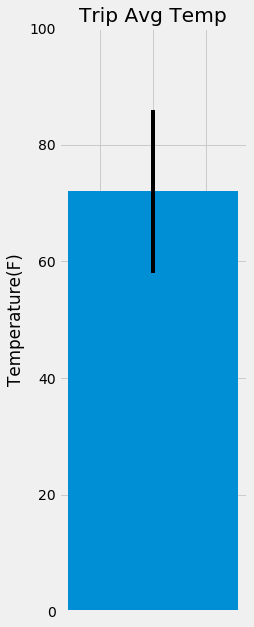

In [96]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,10))
plt.bar([0],info[1])
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylim(0,100)
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temp")
plt.errorbar(0,info[1],yerr=(info[2]-info[0]),color="black")

### 3. Daily Rainfall Average

In [97]:
data_last_day = session.query(measurements.date).order_by(measurements.date.desc()).first()[0]
data_last_day = dt.datetime.strptime(data_last_day,"%Y-%m-%d").date()
qurey_last_day = data_last_day.replace(data_last_day.year+1)
qurey_last_day

datetime.date(2018, 8, 23)

In [98]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# create a query that will calculate the total amount of rainfall per weather station for your tripdates using the previous year's matching dates.

# create a query that will calculate the total amount of rainfall per weather station for your tripdates using the previous year's matching dates.
def precipitation_summation(start_date, end_date):
    start_date = dt.datetime.strptime(start_date,"%Y-%m-%d").date()
    end_date = dt.datetime.strptime(end_date,"%Y-%m-%d").date()
    # estimate if the dataset will cover the dates that we want to query
    
    #1. not cover at all: using the data from year 2017
    if start_date >= qurey_last_day:
        results = session.query(measurements.station,func.sum(measurements.prcp)).\
        filter(measurements.date >= (start_date.replace(year=2017))).\
        filter(measurements.date <= (end_date.replace(year=2017))).\
        group_by(measurements.station).all()
             
        station_name = [result[0] for result in results]
        prcp_sum = [result[1] for result in results]
    
    #2. partly coverd : using the data from year 2016
    elif start_date<qurey_last_day and end_date>qurey_last_day:
        results = session.query(measurements.station,func.sum(measurements.prcp)).\
        filter(measurements.date >= (start_date.replace(year=2016))).\
        filter(measurements.date <= (end_date.replace(year=2016))).\
        group_by(measurements.station).all()
        
        station_name = [result[0] for result in results]
        prcp_sum = [result[1] for result in results]
            
    #3. completely covered: using the data from year queried   
    elif end_date <= qurey_last_day: 
        results = session.query(measurements.station,func.sum(measurements.prcp)).\
        filter(measurements.date >= start_date).\
        filter(measurements.date <= end_date).\
        group_by(measurements.station).all()
        
        station_name = [result[0] for result in results]
        prcp_sum = [result[1] for result in results]
        
        
        
    # create a dataframe that store the information 
    # Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation        
    result_df = pd.DataFrame({"station":station_name,"total precipitaton in the trip":prcp_sum})
    trip_pcrp_info = station_df.merge(result_df,how="inner",on="station").\
                    sort_values("total precipitaton in the trip", ascending=False)
    
    
    return trip_pcrp_info
# function usage example

precipitation_summation('2019-02-28', '2019-03-05')

,station,name,latitude,longitude,elevation,total precipitaton in the trip
5,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.72
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.45
6,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.07
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.74
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.16


In [99]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [101]:
# create a function which is able to extract month and day as a string from year,month,day string.
def new(date):
    elements = date.split("-")
    new_date = elements[1]+"-"+elements[2]
    return new_date

def trip_daily_precipitation(start_date,end_date):
    tmin = []
    tmax = []
    tavg = []
    dates = []
    #convert the input to datatime objects
    start_date = dt.datetime.strptime(start_date,"%Y-%m-%d").date()
    end_date = dt.datetime.strptime(end_date,"%Y-%m-%d").date()
    #calculate the number of days between the start date and end date.
    date_count = (end_date-start_date).days+1
    # Use the start and end date to create a range of dates consisting of year,month and day.
    for a in range(0,date_count):
        dates.append(str(start_date+dt.timedelta(days=a)))

    new_dates = []
    # use new() function to extract month and year, and ttip off the year and save a list of %m-%d stringsto a list named new_dates.
    for date in dates:
        new_date = new(date)
        new_dates.append(new_date)
        
    # Loop through the list of %m-%d strings and calculate the normals for each date
    for date in new_dates: 
        tmin.append(daily_normals(date)[0][0])
        tavg.append(daily_normals(date)[0][1])
        tmax.append(daily_normals(date)[0][2])


    # Load the previous query results into a Pandas DataFrame and add the `dates` range as the `date` index
    trip_daily_precipitation_df = pd.DataFrame({"date":dates,"minimum temperature":tmin,"maximum temperature":tmax,"average temperature":tavg})
    trip_daily_precipitation_df = trip_daily_precipitation_df.sort_values("date",ascending=True).set_index("date")
    trip_daily_precipitation_df
    
    return trip_daily_precipitation_df


daily_df = trip_daily_precipitation('2012-02-03','2012-02-23')                                      

Text(0, 0.5, 'Temperature')

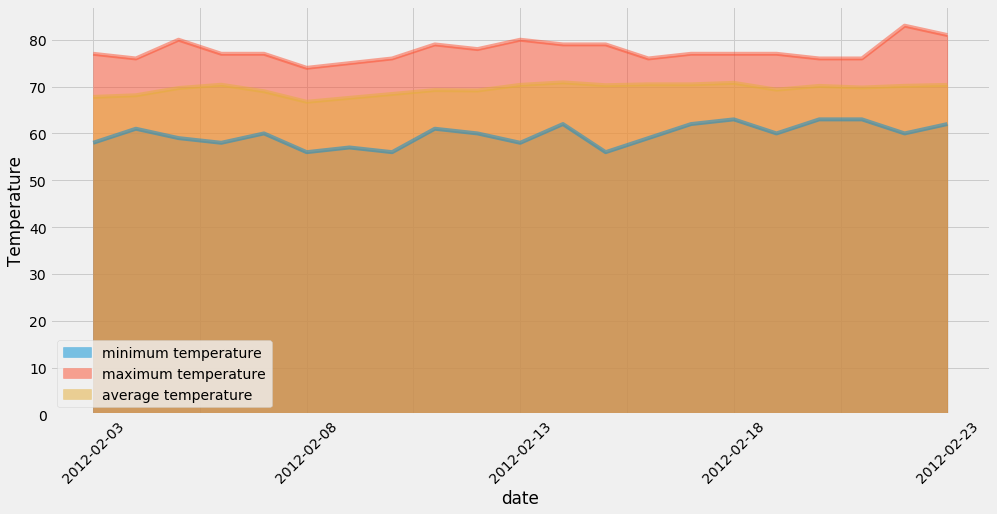

In [102]:
# Plot the daily normals as an area plot with `stacked=False`

plot4 = daily_df.plot.area(stacked=False,rot=45,figsize=(15,7))
plot4.set_ylabel("Temperature")